In [174]:
# Initialize Otter
import otter
grader = otter.Notebook("longshort_strategy part 2.ipynb")

In [175]:
import datetime as dt
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [176]:
def isclose(value, original, tolerance= 0.05):
    return value <= original * (1+tolerance) and value >= original * (1-tolerance)


### Introduction

In this homework, we will explore the foundational tools and techniques required to develop and evaluate a trading strategy. Specifically, we will:

- **Learn and apply Pandas** for data cleaning and preprocessing.
- **Implement a basic trading strategy**, including both long and short positions.
- **Model the costs** associated with executing the strategy, such as transaction fees or slippage.
- **Calculate expected returns** to assess the potential profitability of the strategy.
- **Incorporate expected returns** into an enhanced trading strategy for improved performance.
- **Experiment with predictive features and signals** to refine the strategy further.

By the end of this homework, you will have a solid understanding of how to use data-driven methods to design and evaluate tradin

**Note: For the Spring 2025 semester, we only recommend you complete up to section 7 ("evaluating performance").** The rest of the test cases have not been updated for new data and will likely fail, but you are welcome to work on further sections and ignore the test cases.

# returns

---

### Calculating Return on Investment (ROI) in Finance

To evaluate the performance of any strategy, it is essential to calculate the **return on investment (ROI)**. In finance, we often use **log returns** instead of **simple returns** because of their mathematical advantages.

#### Why Use Log Returns?
- **Ease of Calculations**: Log returns are simpler to work with in mathematical models.
- **Constant Compounding**: Log returns represent continuously compounding returns, allowing us to **add them over time** instead of multiplying.

#### How to Calculate Returns
1. **Simple Returns**:  
   
   $$\text{Simple Return} = \frac{x_1 - x_0}{x_0}$$
   
   This is the **percentage change** from \(x_0\) (initial value) to \(x_1\) (final value).

2. **Log Returns**:  
   
   $$\text{Log Return} = \log\left(\frac{x_1}{x_0}\right)$$
   
   This is the natural logarithm of the ratio between the final and initial values.

---

In [177]:
# see if you can derive the transformations from log returns to simple returns, and simple returns to log returns
hdf = pd.read_parquet('./stock_data.parquet')
hdf.head()

Price        Adj Close                                                        \
Ticker               A    AAL        AAPL        ABBV        ABNB        ABT   
Date                                                                           
2023-10-04  110.917877  12.73  172.585999  141.069550  127.410004  93.262283   
2023-10-05  109.606766  12.85  173.828293  140.840302  124.989998  93.798546   
2023-10-06  109.894814  12.76  176.392334  141.594879  126.360001  94.461571   
2023-10-09  110.530510  12.24  177.883041  142.425888  127.769997  94.344574   
2023-10-10  112.526970  12.26  177.286758  142.215759  131.589996  95.124588   

Price                                                      ...  Volume  \
Ticker           ACGL         ACN        ADBE         ADI  ...     WTW   
Date                                                       ...           
2023-10-04  76.509293  303.237457  518.419983  170.809814  ...  749100   
2023-10-05  77.631355  303.502045  516.440002  169.148819  ...  855000   
2023-10-06  78.144844  305.981781  526.679993  170.986740  ...  897700   
2023-10-09  78.040245  305.805359  529.289978  170.347885  ...  655500   
2023-10-10  77.840553  306.109161  532.719971  172.952438  ...  478400   

Price                                                                       \
Ticker           WY     WYNN      XEL       XOM      XYL      YUM      ZBH   
Date                                                                         
2023-10-04  3954000  2289300  3948700  19622200  1614400  1381200  1597600   
2023-10-05  3724500  1513600  3835400  20128800  1131000  1240200  1048200   
2023-10-06  4318300  2470600  6337200  25363400  1149700  2111900  1570500   
2023-10-09  3171800  1622800  2702100  22369900   949500  1840000   865900   
2023-10-10  3078500  1674800  3117900  13892000  1478800  1643300   999400   

Price                        
Ticker        ZBRA      ZTS  
Date                         
2023-10-04  487500  1673400  
2023-10-05  448400  2083200  
2023-10-06  384000  1490600  
2023-10-09  266600  1215100  
2023-10-10  361900  1665300  

[5 rows x 994 columns]

In [178]:
# use np.exp
def logtosimple(logreturn):
    return np.exp(logreturn) -1

In [179]:
grader.check("q3a")

q3a results: All test cases passed!

In [180]:
# use np.log
def simpletolog(simplereturn):
    return np.log(simplereturn) 

In [181]:
grader.check("q3b")

q3b results:
    q3b - 1 result:
        ❌ Test case failed
        Trying:
            assert np.isclose(simpletolog(1),0.6931471805599453)
        Expecting nothing
        **********************************************************************
        Line 1, in q3b 0
        Failed example:
            assert np.isclose(simpletolog(1),0.6931471805599453)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q3b 0[0]>", line 1, in <module>
                assert np.isclose(simpletolog(1),0.6931471805599453)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

In [182]:
# let's look at an example asset
# create a dataframe that is just the adjusted close and volume for AAL
aal = hdf.loc[:,hdf.columns.get_level_values(1) == "AAL"]
aal.head()

Price,Adj Close,Volume
Ticker,AAL,AAL
Date,,
2023-10-04,12.73,49738100
2023-10-05,12.85,36272900
2023-10-06,12.76,31822200
2023-10-09,12.24,51462700
2023-10-10,12.26,37144200


In [183]:
grader.check("q3c")

q3c results: All test cases passed!

Let's remove the top level of the columns in order to make things easier - we already know the symbol is AAL

In [184]:
aal.columns = aal.columns.get_level_values(0)
aal.head()

Price,Adj Close,Volume
Date,,
2023-10-04,12.73,49738100
2023-10-05,12.85,36272900
2023-10-06,12.76,31822200
2023-10-09,12.24,51462700
2023-10-10,12.26,37144200


In [185]:
grader.check("q3d")

q3d results: All test cases passed!

To calculate returns for **AAL**, create a new column by applying `.pct_change()` to the **adjusted close** column.

In [186]:
aal['returns'] = aal["Adj Close"].pct_change()
aal.head()

Price,Adj Close,Volume,returns
Date,,,
2023-10-04,12.73,49738100,NaN
2023-10-05,12.85,36272900,0.009427
2023-10-06,12.76,31822200,-0.007004
2023-10-09,12.24,51462700,-0.040752
2023-10-10,12.26,37144200,0.001634


In [187]:
grader.check("q3e")

q3e results: All test cases passed!

In [188]:
# we can get the log returns by adjusting the percent change function

aal['logreturns'] = (aal["Adj Close"].apply(simpletolog)).diff()
aal.head()

Price,Adj Close,Volume,returns,logreturns
Date,,,,
2023-10-04,12.73,49738100,NaN,NaN
2023-10-05,12.85,36272900,0.009427,0.009382
2023-10-06,12.76,31822200,-0.007004,-0.007029
2023-10-09,12.24,51462700,-0.040752,-0.041606
2023-10-10,12.26,37144200,0.001634,0.001633


In [189]:
grader.check("q3f")

q3f results: All test cases passed!

In [190]:
# .cumsum() on a series will add everything in the column up until that point
# this will give us the log return from the start, to the current index
aal['cum_logreturns'] = aal['logreturns'].cumsum()
aal.head()

Price,Adj Close,Volume,returns,logreturns,cum_logreturns
Date,,,,,
2023-10-04,12.73,49738100,NaN,NaN,NaN
2023-10-05,12.85,36272900,0.009427,0.009382,0.009382
2023-10-06,12.76,31822200,-0.007004,-0.007029,0.002354
2023-10-09,12.24,51462700,-0.040752,-0.041606,-0.039252
2023-10-10,12.26,37144200,0.001634,0.001633,-0.037619


In [191]:
grader.check("q3g")

q3g results: All test cases passed!

<Axes: xlabel='Date'>

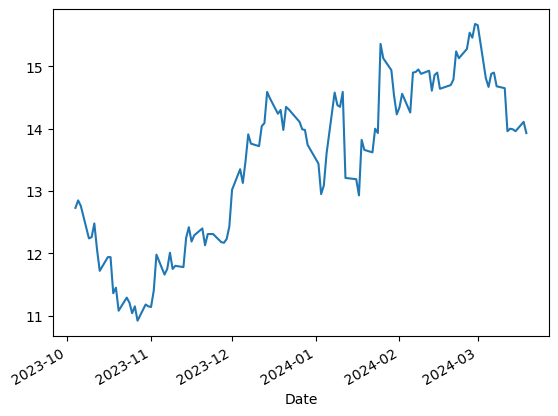

In [192]:
# pandas also comes equipped with some built in plotting
# we can plot the adjusted close, as well as the logreturns cumsum, and see if they look the same (they should)
aal['Adj Close'].plot()

<Axes: xlabel='Date'>

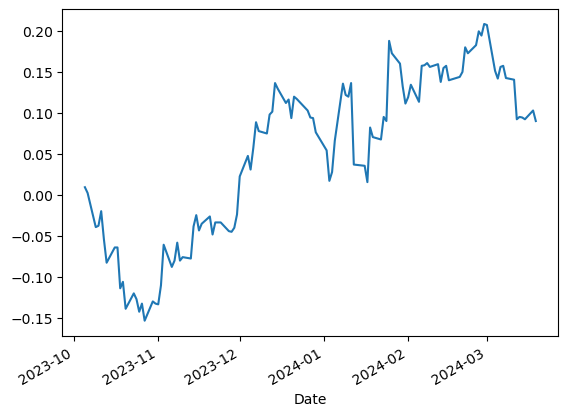

In [193]:
aal['cum_logreturns'].plot()

# Basic trend strategy: long/short by percentile

---
### Developing a Trading Strategy

Now, let’s work on creating a **trading strategy** with the following assumptions:

- **Shorting Allowed**: We assume that we can short stocks.
- **Zero Borrowing Cost**: For simplicity, we assume the cost to borrow is **0** (note: this is a non-trivial assumption).

#### Strategy Overview
Our goal is to:
- **Buy (go long)** stocks expected to increase in value.
- **Sell (go short)** stocks expected to decrease in value.

#### Approach
1. **Ranking Stocks**:  
   We will rank stocks based on a chosen **metric** (e.g., momentum, valuation ratios, or other factors).

2. **Position Allocation**:  
   - Go **long** on the top percentage of stocks ranked by the metric.
   - Go **short** on the bottom percentage of stocks ranked by the metric.

This approach allows us to systematically identify opportunities and construct a portfolio based on clear criteria.

---

In [194]:
hdf

Price        Adj Close                                                         \
Ticker               A    AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                            
2023-10-04  110.917877  12.73  172.585999  141.069550  127.410004   93.262283   
2023-10-05  109.606766  12.85  173.828293  140.840302  124.989998   93.798546   
2023-10-06  109.894814  12.76  176.392334  141.594879  126.360001   94.461571   
2023-10-09  110.530510  12.24  177.883041  142.425888  127.769997   94.344574   
2023-10-10  112.526970  12.26  177.286758  142.215759  131.589996   95.124588   
...                ...    ...         ...         ...         ...         ...   
2024-03-13  147.072739  14.00  170.513031  175.174911  164.759995  118.378120   
2024-03-14  144.475922  13.99  172.376282  176.479996  166.440002  117.087540   
2024-03-15  146.734451  13.96  171.997650  173.246490  160.639999  113.777367   
2024-03-18  145.351471  14.11  173.093674  173.840591  161.860001  110.772606   
2024-03-19  146.644913  13.93  175.445190  174.980118  161.789993  111.481926   

Price                                                      ...  Volume  \
Ticker           ACGL         ACN        ADBE         ADI  ...     WTW   
Date                                                       ...           
2023-10-04  76.509293  303.237457  518.419983  170.809814  ...  749100   
2023-10-05  77.631355  303.502045  516.440002  169.148819  ...  855000   
2023-10-06  78.144844  305.981781  526.679993  170.986740  ...  897700   
2023-10-09  78.040245  305.805359  529.289978  170.347885  ...  655500   
2023-10-10  77.840553  306.109161  532.719971  172.952438  ...  478400   
...               ...         ...         ...         ...  ...     ...   
2024-03-13  86.531769  374.089264  573.549988  197.038223  ...  530100   
2024-03-14  86.560295  373.585510  570.450012  192.901001  ...  482900   
2024-03-15  87.368553  370.019684  492.459991  193.664948  ...  885400   
2024-03-18  86.912125  368.113281  513.859985  189.716248  ...  402800   
2024-03-19  87.168869  373.457092  521.190002  189.041595  ...  579000   

Price                                                                        \
Ticker           WY     WYNN       XEL       XOM      XYL      YUM      ZBH   
Date                                                                          
2023-10-04  3954000  2289300   3948700  19622200  1614400  1381200  1597600   
2023-10-05  3724500  1513600   3835400  20128800  1131000  1240200  1048200   
2023-10-06  4318300  2470600   6337200  25363400  1149700  2111900  1570500   
2023-10-09  3171800  1622800   2702100  22369900   949500  1840000   865900   
2023-10-10  3078500  1674800   3117900  13892000  1478800  1643300   999400   
...             ...      ...       ...       ...      ...      ...      ...   
2024-03-13  2508500  1138400   5420000  17122200   872500  3361400   847000   
2024-03-14  4124900  1882700  11860000  22121000  1335500  3091900  1203900   
2024-03-15  6848900  4404600  11153200  38263900  1537600  4164800  2672400   
2024-03-18  3373100  1528700   7217700  16770500   720000  2384500   972300   
2024-03-19  2496400  1444100   5656800  14878800   806900  2266500   949300   

Price                        
Ticker        ZBRA      ZTS  
Date                         
2023-10-04  487500  1673400  
2023-10-05  448400  2083200  
2023-10-06  384000  1490600  
2023-10-09  266600  1215100  
2023-10-10  361900  1665300  
...            ...      ...  
2024-03-13  286200  5947400  
2024-03-14  375300  6432600  
2024-03-15  539300  3399500  
2024-03-18  329300  4955000  
2024-03-19  306000  3624000  

[115 rows x 994 columns]

In [195]:
# to more easily group by asset, we'll make assets into its own column using df.stack()
hdf_old = hdf.copy()
hdf = (
    hdf.stack()
    .reset_index()
    .rename(columns={'level_1': 'Symbol'})
)
hdf

Price,Date,Ticker,Adj Close,Volume
0,2023-10-04,A,110.917877,1541700.0
1,2023-10-04,AAL,12.730000,49738100.0
2,2023-10-04,AAPL,172.585999,53020300.0
3,2023-10-04,ABBV,141.069550,3159600.0
4,2023-10-04,ABNB,127.410004,5822000.0
...,...,...,...,...
57150,2024-03-19,XYL,127.775208,806900.0
57151,2024-03-19,YUM,135.940338,2266500.0
57152,2024-03-19,ZBH,125.862167,949300.0
57153,2024-03-19,ZBRA,285.190002,306000.0


### Calculating Returns and Log Returns

To compute **returns** and **log returns** for the entire dataset, we can **group by the ticker**, select the adjusted close column, and then use .pct_change() to get the percentage change from one row to the next

These steps will provide the necessary data to derive both simple and log returns for analysis. 

In [196]:
hdf['returns'] = hdf.groupby("Ticker")["Adj Close"].pct_change()
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns
0,2023-10-04,A,110.917877,1541700.0,NaN
1,2023-10-04,AAL,12.730000,49738100.0,NaN
2,2023-10-04,AAPL,172.585999,53020300.0,NaN
3,2023-10-04,ABBV,141.069550,3159600.0,NaN
4,2023-10-04,ABNB,127.410004,5822000.0,NaN


In [197]:
grader.check("q4a")

q4a results: All test cases passed!

### Creating a Log Returns Column

To calculate log returns, we'll create a new column in the dataset. This involves applying our **simple-to-log** function to the data and assigning the results to a column named `logreturns`.

This new column will represent the log-transformed returns for each data point.

In [198]:
hdf['logreturns'] = (1 + hdf['returns']).apply(simpletolog)
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns
0,2023-10-04,A,110.917877,1541700.0,NaN,NaN
1,2023-10-04,AAL,12.730000,49738100.0,NaN,NaN
2,2023-10-04,AAPL,172.585999,53020300.0,NaN,NaN
3,2023-10-04,ABBV,141.069550,3159600.0,NaN,NaN
4,2023-10-04,ABNB,127.410004,5822000.0,NaN,NaN


In [199]:
grader.check("q4b")

q4b results: All test cases passed!

### Creating a Forward Log Return Column

To predict the next step of returns, we need to create a column for the **forward log return**. Here's how to do it:

1. **Group by Ticker**: Group the data by the stock ticker to ensure calculations are performed within each stock's data.

2. **Select Log Returns**: Focus on the column containing the log returns.

3. **Shift the Series**: Use `.shift(-1)` to move the series **up one row**, aligning the future return with the current row.  
   Refer to the [pandas.DataFrame.shift documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) for more details.

This process creates a new column that represents the **forward log return**, which can be used as the target variable for prediction models.

In [200]:
hdf['fwd_logreturn'] = hdf.groupby("Ticker")["logreturns"].shift(-1)
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn
0,2023-10-04,A,110.917877,1541700.0,NaN,NaN,-0.011891
1,2023-10-04,AAL,12.730000,49738100.0,NaN,NaN,0.009382
2,2023-10-04,AAPL,172.585999,53020300.0,NaN,NaN,0.007172
3,2023-10-04,ABBV,141.069550,3159600.0,NaN,NaN,-0.001626
4,2023-10-04,ABNB,127.410004,5822000.0,NaN,NaN,-0.019177


In [201]:
grader.check("q4c")

q4c results: All test cases passed!

### Dropping Rows with NaN Values

To avoid issues in future operations, we need to drop rows where **log returns** or **forward log returns** contain `NaN` values. This can be done using the `subset` parameter in `df.dropna(subset=[])`

In [202]:
hdf = hdf.dropna(subset=["logreturns", "fwd_logreturn"])
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901


In [203]:
grader.check("q4d")

q4d results: All test cases passed!

# Momentum

---

### Ranking Returns by Asset

To develop a strategy, we can **rank the returns** for each asset. 

#### Observations:
- **Momentum Tendency**:  
  We might guess that stocks that have **gone up** tend to continue rising, while stocks that have **gone down** tend to keep falling.  

#### Why Might This Happen?  
We might guess:
- A stock that has risen significantly might attract buyers who want to **join the trend**, driving the price higher.
- Conversely, a stock that has fallen may face additional selling pressure from investors exiting their positions.

#### Strategy:
- **Buy (Go Long)**: Identify and buy the stocks that have risen the most.  
- **Sell (Go Short)**: Identify and short the stocks that have fallen the most.

---


### Calculating Ranks Using `.rank()`

To calculate ranks for log returns, we can use the `.rank()` method. This method assigns a rank value as if the DataFrame were sorted. Key steps:

1. **Descending Order**: Use `ascending=False` to rank in descending order.
2. **Dense Ranking**: Specify `method='dense'` to ensure that ranks are consecutive even when there are ties.
3. **Group by Date**: Group the data by date to calculate ranks within each group.
4. **Assign to a New Column**: Create a new column, `logreturn_rank`, to store the ranks of the `logreturns` column.

Refer to the [pandas.DataFrame.rank documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html) for more details.

In [204]:
hdf['logreturn_rank'] = hdf.groupby("Date")["logreturns"].rank(ascending=False, method='dense')
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0


In [205]:
grader.check("q5a")

q5a results: All test cases passed!

In [206]:
# we can also look at the demeaned returns, or the returns of the asset we chose relative to all assets
# this will help us assess if we were able to choose the assets that would end up under/overperforming

date_mean_logreturns = hdf.groupby('Date')['logreturns'].transform('mean')

# Calculate the demeaned log returns
hdf['demeaned_logreturn'] = hdf['logreturns'] - date_mean_logreturns

# Similar to the above, calculate the mean *forward* log returns for each date
date_mean_fwd_logreturns = hdf.groupby("Date")["fwd_logreturn"].transform('mean')

# Calculate the demeaned forward log returns
hdf['demeaned_fwd_logreturn'] = hdf['fwd_logreturn'] - date_mean_fwd_logreturns
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279


In [207]:
grader.check("q5b")

q5b results: All test cases passed!

In [208]:
# for ease of analyzing the effect, we will bucket our feature using a decile (each bin is 10%-ile)
# this will help us figure out how strong the effect is
# we do this using pd.qcut(x, q=quantile, labels=False, duplicates='drop'), which cuts a series into quantile buckets. pass q=10 to get decile buckets
# [https://pandas.pydata.org/docs/reference/api/pandas.qcut.html]
# drop labels and duplicates
hdf['logreturn_decile'] = hdf.groupby('Date')['logreturns'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1


<Axes: xlabel='logreturn_decile'>

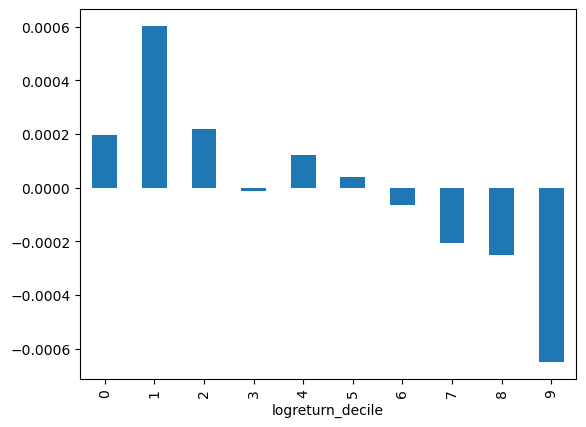

In [209]:
# we'll plot this using a barplot
hdf.groupby('logreturn_decile').mean(numeric_only = True)['demeaned_fwd_logreturn'].plot(kind='bar')

In [210]:
# it definitely looks like the bottom and top 20%-ile have outsized returns!

# Strategy 'backtesting'

---

### Backtesting: A Simplified Approach


This simplified backtest provides a quick way to assess the viability of features before diving into more complex analyses.

--- 

In [211]:
# let's define our strategy by setting an asset to be long or short if its in the top or bottom 20% log return decile
# we'll also equal weight all our positions
# the decile values for the bottom 20% would be 0 and 1
# the decile values for the top 20% would be 8 and 9

# we can use np.where() in order to conditionally assign a column
hdf['long/short'] = np.where(hdf["logreturn_decile"] < 2, -1,
                      np.where(hdf["logreturn_decile"] > 7, 1, 0))
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1


In [212]:
grader.check("q6a")

q6a results: All test cases passed!

In [213]:
# we size our positions by taking our absolute long/short position
hdf['absposition'] = hdf['long/short'].abs()
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short,absposition
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0,0
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1,1
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1,1
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0,0
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1,1


In [214]:
grader.check("q6b")

q6b results: All test cases passed!

In [215]:
# getting the total number of our positions by summing our absolute position for each day 
# hint: take a look at .transform documentation [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html]
hdf['numpositions'] = hdf.groupby("Date")["absposition"].transform('sum')
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short,absposition,numpositions
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0,0,200
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1,1,200
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1,1,200
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0,0,200
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1,1,200


In [216]:
grader.check("q6c")

q6c results: All test cases passed!

In [217]:
# and we get our final weight for each asset by scaling our long/short indicator variable by the number of positions we have
# each position should be such that we add up to one, so we'd divide the indicator by total positions
# if we have 0 positions, the weight should be 0
# this will mean that we should have equal size long and short, adding up to a total of 1 (no leverage)
# we'll use df.apply(lambda row: (expression using row) if (condition on some row) else value, axis=1)

hdf['weight'] = hdf.apply(lambda row: row['long/short'] / row['numpositions'] if row['numpositions'] != 0 else 0, axis=1)
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short,absposition,numpositions,weight
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0,0,200,0.000
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1,1,200,0.005
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1,1,200,0.005
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0,0,200,0.000
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1,1,200,-0.005


In [218]:
grader.check("q6d")

q6d results: All test cases passed!

In [219]:
# finally we define the strategy's return as the weighted logreturns based on our position
# so we multiply weight by forward logreturn
hdf['strategy_logreturn'] = hdf["weight"] * hdf["fwd_logreturn"]
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short,absposition,numpositions,weight,strategy_logreturn
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0,0,200,0.000,0.000000
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1,1,200,0.005,-0.000035
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1,1,200,0.005,0.000073
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0,0,200,0.000,0.000000
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1,1,200,-0.005,-0.000055


In [220]:
grader.check("q6e")

q6e results: All test cases passed!

In [221]:
# we can compare this with an equal weighted strategy, where we long each asset the same amount, again summing up to 1
# hint: use .unique() to get number of assets [https://pandas.pydata.org/docs/reference/api/pandas.unique.html]

hdf['eqweight'] = 1 / hdf["Ticker"].nunique()
hdf['equal_logreturn'] = hdf["eqweight"] * hdf["fwd_logreturn"]
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,logreturn_decile,long/short,absposition,numpositions,weight,strategy_logreturn,eqweight,equal_logreturn
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,2,0,0,200,0.000,0.000000,0.002012,0.000005
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,8,1,1,200,0.005,-0.000035,0.002012,-0.000014
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,8,1,1,200,0.005,0.000073,0.002012,0.000029
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,5,0,0,200,0.000,0.000000,0.002012,0.000011
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,1,-1,1,200,-0.005,-0.000055,0.002012,0.000022


In [222]:
grader.check("q6f")

q6f results: All test cases passed!

# Evaluating performance

<Axes: xlabel='Date'>

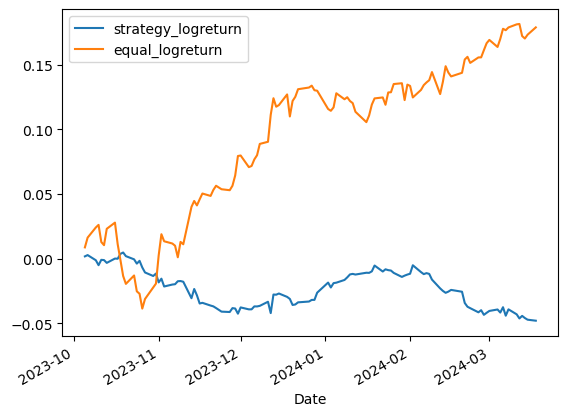

In [223]:
hdf.groupby('Date').sum()['strategy_logreturn'].cumsum().plot(legend=True)
hdf.groupby('Date').sum()['equal_logreturn'].cumsum().plot(legend=True)

In [224]:
# we can get the final return by getting the last value of the column (values[-1])
# and we can translate that to simple returns for readability
final_strategyreturn = logtosimple(hdf.groupby('Date').sum()['strategy_logreturn'].cumsum().values[-1])
final_equalreturn = logtosimple(hdf.groupby('Date').sum()['equal_logreturn'].cumsum().values[-1])

print(f'final_strategyreturn: {final_strategyreturn}')
print(f'final_equalreturn: {final_equalreturn}')

final_strategyreturn: -0.046931507156795726
final_equalreturn: 0.19573618511585034


In [225]:
grader.check("q7a")

q7a results: All test cases passed!

---

### Evaluating Strategy Performance

The equal-weight strategy significantly outperformed our strategy. Given the simplicity of our approach, this outcome is not unexpected. However, the equal-weight strategy also exhibited notable **volatility**. 

To better account for volatility, we can use the **Sharpe Ratio**. 

#### Understanding the Sharpe Ratio
The Sharpe Ratio measures the **risk-adjusted return** of a strategy and can be thought of as a t-test for the statistical significance of the returns. It is calculated as:  

$$ \text{Sharpe Ratio} = \frac{\text{Mean Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Returns}}$$

Benerally, any sharpe ratio over 1 is good, 2 is very good, 3+ is very very good. As you see a sharpe ratio > 3, the more likely that the strategy is somehow limited, or you've calculated something wrong

#### Important Caveats
In this example, the calculated Sharpe Ratios are **not realistic** due to several simplifications. For instance:
- **Lookahead Bias**: Restricting the universe to companies currently in the S&P 500 introduces bias, as we are using information unavailable in past periods (e.g., in 2023).

There are likely other ways this sample or testing strategy might be limited. Consider exploring additional potential biases or flaws in the approach!

--- 

In [226]:
# let's calculate the sharpe ratio with a function, we'll leave out the risk free rate part of it for now
# we also need to normalize the sharpe ratio with respect to a year, by multiplying by the square root of periods our strategy trades in a year
# note that there are 252 trading days

def sharpe_ratio(mean_ret, std_ret):
    return (mean_ret/std_ret) * np.sqrt(252)
    
strat_sharpe = sharpe_ratio(hdf.groupby('Date').sum()['strategy_logreturn'].mean(), 
             hdf.groupby('Date').sum()['strategy_logreturn'].std())
equal_sharpe = sharpe_ratio(hdf.groupby('Date').sum()['equal_logreturn'].mean(), 
             hdf.groupby('Date').sum()['equal_logreturn'].std())
print(strat_sharpe, equal_sharpe)

-1.8403958685454378 3.104487368515163


In [227]:
grader.check("q7c")

q7c results: All test cases passed!

---

### Observations on Strategy Performance

Interestingly, the equal-weight strategy showed a very high Sharpe Ratio. This is likely due to the period from October 2023 to March 2024 being particularly bullish. You can verify this by checking the S&P 500 returns during that time.

To minimize the impact of such market-specific idiosyncrasies, it is generally better to backtest over a longer time horizon, such as a year or more. This helps reduce variance and provides a more robust evaluation of the strategy.

--- 

# That's it for sp25!
This is all we recommend you complete this semester.
If you're interested, you may keep doing the next cells. However, because the yfinance data changed, the test cases below will fail, so please ignore them. Again, the below is all optional.

# accounting for fees

In [228]:
# this is without fees so it is clearly way too good
# let's add a fee for each trade, and expected slippage per trade
# the fee is what we would pay to the broker, and the expected slippage is likely a function of our position size
# we'll combine these into one value, and just observe how our strategy decays as a function of cost

# let's define a percentage fee per trade (e.g., 0.02%)
fee = 0.0002

In [229]:
# in order to see how large our trade would be, we have to find the difference between our previous and current position size
# we should sort values by symbol, then by the date
hdf = hdf.sort_values(by=["Ticker", "Date"]) # order matters!

# we'll groupby symbol, and then get the previous weight by using .shift(1) to shift the weights down
hdf['prevweight'] = hdf.groupby('Ticker')['weight'].shift(1)

# next, we'll get the strategy's weight change by taking the difference between weight and prevweight
hdf['strategy_weightchange'] = hdf["weight"] - hdf["prevweight"]

# finally, to calculate fees, we'll need to multiply the fee by our absolute change in position
hdf['strategy_fees'] = abs(hdf['strategy_weightchange']) * fee
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,...,long/short,absposition,numpositions,weight,strategy_logreturn,eqweight,equal_logreturn,prevweight,strategy_weightchange,strategy_fees
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,...,0,0,200,0.000,0.000000,0.002012,0.000005,NaN,NaN,NaN
994,2023-10-06,A,109.894814,1796100.0,0.002628,0.002625,0.005768,367.0,-0.005998,-0.001795,...,0,0,200,0.000,0.000000,0.002012,0.000012,0.000,0.000,0.000000
1491,2023-10-09,A,110.530510,1320300.0,0.005785,0.005768,0.017901,258.0,-0.001795,0.010052,...,0,0,200,0.000,0.000000,0.002012,0.000036,0.000,0.000,0.000000
1988,2023-10-10,A,112.526970,2183000.0,0.018063,0.017901,0.000794,77.0,0.010052,-0.001212,...,1,1,200,0.005,0.000004,0.002012,0.000002,0.000,0.005,0.000001
2485,2023-10-11,A,112.616356,1381500.0,0.000794,0.000794,-0.039948,296.0,-0.001212,-0.026702,...,0,0,200,0.000,-0.000000,0.002012,-0.000080,0.005,-0.005,0.000001


In [230]:
grader.check("q8a")

q8a results: All test cases passed!

<Axes: xlabel='Date'>

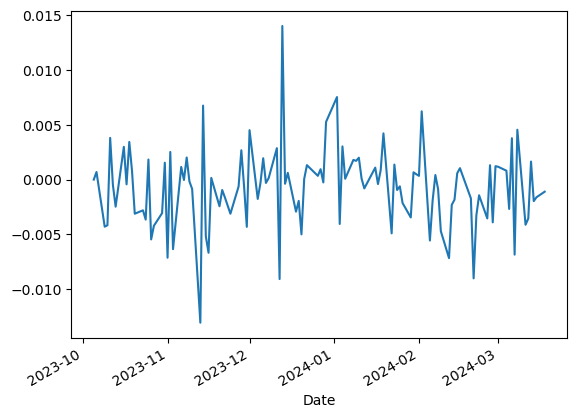

In [231]:
# now we'll calculate the strategy log return after fees by subtracting the groupby fees from the groupby logreturn
hdf['strategy_postfees'] = hdf["strategy_logreturn"] - hdf["strategy_fees"]
strategy_postfees_seriestoplot = hdf.groupby("Date")["strategy_postfees"].sum()
strategy_postfees_seriestoplot.plot()

In [232]:
grader.check("q8b")

q8b results: All test cases passed!

In [233]:
# and we'll test the sharpe and logreturn as above
fees_sharpe = sharpe_ratio(hdf.groupby('Date').sum()['strategy_postfees'].mean(), hdf.groupby('Date').sum()['strategy_postfees'].std())
fees_sharpe

np.float64(-3.261402456852923)

In [234]:
grader.check("q8c")

q8c results: All test cases passed!

In [235]:
# note that the equal weight buy and hold does not change with fees, as it never changes position

# expected returns

In [236]:
# now that we have a very basic long/short strategy, we should try to improve upon it

# our strategy roughly was equally long and short the market - regardless of how strongly something moved
# even if all of the longs were very high return, the strategy didn't care
# it also didn't care if it was 10th or 20th decile: we gave the same weight regardless
# we might expect that there's a way to improve upon this

# one way of doing this is trying to calculate an 'expected return' for each asset
# this allows us to weight our positions based on how good we think they are

In [237]:
# how might we make an expected returns model? 
# we'll likely want to fit to some historical data, and see how that strategy performs on data after that

# to avoid our model just learning the optimal answer for our entire dataset
# we'll train the model on the first 80% of our data
# and see how it performs on the remaining 20%

In [238]:
# split the data into training and testing using .iloc
train_percent = 0.8 # use 80% as a decimal
# make sure to split according to time series!

hdf = hdf.sort_values(["Date", "Ticker"]) # order matters! we need to split by time first, then asset

# we can only use integer indices, so make sure to cast the value to an integer
splitrow = round(hdf.shape[0] * train_percent)
training = hdf.iloc[:splitrow]
testing = hdf.iloc[splitrow:]

In [239]:
grader.check("q9a")

q9a results:
    q9a - 1 result:
        ❌ Test case failed
        Trying:
            assert training.shape == (45508, 22)
        Expecting nothing
        **********************************************************************
        Line 1, in q9a 0
        Failed example:
            assert training.shape == (45508, 22)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q9a 0[0]>", line 1, in <module>
                assert training.shape == (45508, 22)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

In [240]:
# a very common basic model is a linear regression: fitting a line to points of data
# given some x variable, we try to solve for the optimal y = mx + b, 
# we do this by minimizing the squared sum of differences of our line to each data point
# luckily there are libraries that do this for us

In [241]:
# to run a linear regression on our training data, we need a data matrix X of features
# and a target y to fit to 
# in our case, our target is forward log return
# and our data matrix X is the current log returns
# let's run the regression using statsmodels
hdf.head()

Price,Date,Ticker,Adj Close,Volume,returns,logreturns,fwd_logreturn,logreturn_rank,demeaned_logreturn,demeaned_fwd_logreturn,...,absposition,numpositions,weight,strategy_logreturn,eqweight,equal_logreturn,prevweight,strategy_weightchange,strategy_fees,strategy_postfees
497,2023-10-05,A,109.606766,1295700.0,-0.011821,-0.011891,0.002625,392.0,-0.008552,-0.005998,...,0,200,0.000,0.000000,0.002012,0.000005,NaN,NaN,NaN,NaN
498,2023-10-05,AAL,12.850000,36272900.0,0.009427,0.009382,-0.007029,71.0,0.012721,-0.015651,...,1,200,0.005,-0.000035,0.002012,-0.000014,NaN,NaN,NaN,NaN
499,2023-10-05,AAPL,173.828293,48527900.0,0.007198,0.007172,0.014643,99.0,0.010511,0.006020,...,1,200,0.005,0.000073,0.002012,0.000029,NaN,NaN,NaN,NaN
500,2023-10-05,ABBV,140.840302,3599500.0,-0.001625,-0.001626,0.005343,242.0,0.001712,-0.003279,...,0,200,0.000,0.000000,0.002012,0.000011,NaN,NaN,NaN,NaN
501,2023-10-05,ABNB,124.989998,7630200.0,-0.018994,-0.019177,0.010901,443.0,-0.015838,0.002279,...,1,200,-0.005,-0.000055,0.002012,0.000022,NaN,NaN,NaN,NaN


In [242]:
feature = ["logreturns"]
target = ["fwd_logreturn"]

# we add a constant to data matrix Xin order to get an intercept term, otherwise we would be fitting y = mx
X = training[feature]
X = sm.add_constant(X)

y = training[target]

model = sm.OLS(y, X).fit()
print(model.params)

const         0.001557
logreturns    0.009839
dtype: float64


In [243]:
grader.check("q9b")

q9b results:
    q9b - 1 result:
        ❌ Test case failed
        Trying:
            model.rsquared
        Expecting:
            0.05403784673350487
        **********************************************************************
        Line 1, in q9b 0
        Failed example:
            model.rsquared
        Expected:
            0.05403784673350487
        Got:
            np.float64(9.628299648500871e-05)

    q9b - 2 result:
        ❌ Test case failed
        Trying:
            assert isclose(model.rsquared, 0.05333756613777707)
        Expecting nothing
        **********************************************************************
        Line 1, in q9b 1
        Failed example:
            assert isclose(model.rsquared, 0.05333756613777707)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q9b 1[0]>", line 1, in <module>
                assert isclose(model.rsquared, 0.05333756613777707)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

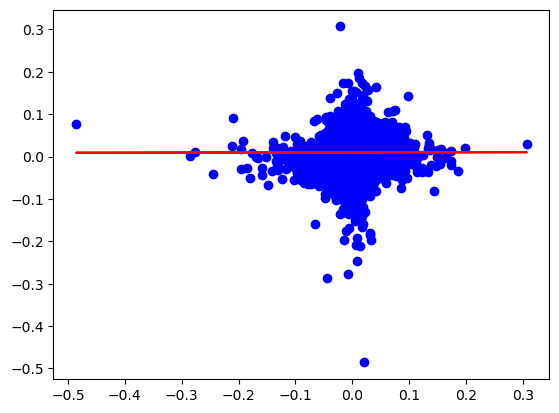

In [244]:
# now we can plot our linear regression

m = model.params["const"]
b = model.params["logreturns"]

# Create a scatter plot
plt.scatter(training[feature], y, color='blue', label='Data')

# Plot the linear regression line
plt.plot(training[feature], m * training[feature] + b, color='red', label='linear regression')

In [245]:
grader.check("q9c")

q9c results:
    q9c - 1 result:
        ❌ Test case failed
        Trying:
            assert isclose(model.params['logreturns'], 0.2324590858601042)
        Expecting nothing
        **********************************************************************
        Line 1, in q9c 0
        Failed example:
            assert isclose(model.params['logreturns'], 0.2324590858601042)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q9c 0[0]>", line 1, in <module>
                assert isclose(model.params['logreturns'], 0.2324590858601042)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

    q9c - 2 result:
        ❌ Test case failed
        Trying:
            assert isclose(model.params['const'], 0.0011427008449693891)
        Expecting nothing
        **********************************************************************
        Line 1, in q9c 1
        Failed example:
            assert isclose(model.params['const'], 0.0011427008449693891)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q9c 1[0]>", line 1, in <module>
                assert isclose(model.params['const'], 0.0011427008449693891)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

In [246]:
# now we can see how well our model does on our testing data
X_test = sm.add_constant(testing[feature])
y_pred = model.predict(X_test).values

# we compare the predictions to the actual values
y_test = testing['logreturns'].values

# we use mean squared error: the mean difference between y_test and y_pred, squared
mse = ((y_test - y_pred)**2).mean()
mse

np.float64(0.0002834856608026062)

In [247]:
grader.check("q9d")

q9d results: All test cases passed!

# updating backtest 

In [248]:
# we also can look at our model's sharpe ratio on the testing data

<Axes: xlabel='Date'>

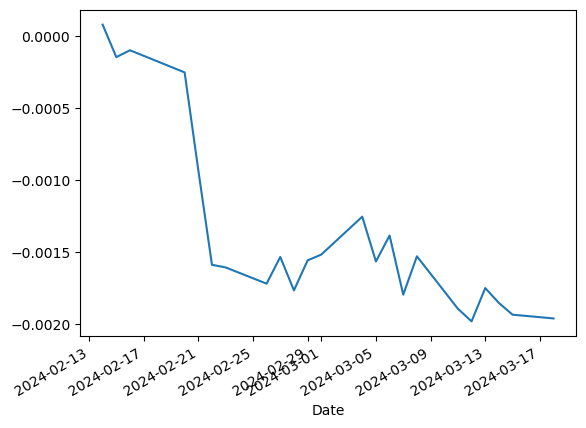

In [249]:

# we can get the expected log returns by applying our model, with a constant, to the feature column

testing['ex_logreturns'] = model.predict(sm.add_constant(testing[feature]))

# we'll size our weights according to the cross sectional predictions
# use transform again to do this
# we want to have each weight be (ex_logreturn-mean ex_logreturn for date)/(sum of absolute ex_logreturns for date)

testing['ex_weight'] = testing.groupby('Date')['ex_logreturns'].transform(
    lambda x: (x - x.mean()) / x.abs().sum()
)

# and we multiply the forward log returns again
testing['exstrategy_logreturns'] = testing['ex_weight'] * testing['fwd_logreturn']

# and we plot once more
testing.groupby('Date').sum()['exstrategy_logreturns'].cumsum().plot()

In [250]:
grader.check("q10a")

q10a results:
    q10a - 1 result:
        ❌ Test case failed
        Trying:
            assert isclose(testing['exstrategy_logreturns'].mean(), 1.0620373849221123e-06)
        Expecting nothing
        **********************************************************************
        Line 1, in q10a 0
        Failed example:
            assert isclose(testing['exstrategy_logreturns'].mean(), 1.0620373849221123e-06)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10a 0[0]>", line 1, in <module>
                assert isclose(testing['exstrategy_logreturns'].mean(), 1.0620373849221123e-06)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

In [251]:
# wow that looks very promising! let's calculate the sharpe ratio with fees
# sort again
testing = testing.sort_values(["Ticker", "Date"])
# get previous ex_weight as before
testing['prevex_weight'] = testing['ex_weight'].shift(1)
# get change in weight as before
testing['exstrategy_weightchange'] = testing['ex_weight'] - testing['prevex_weight']

# get absolute change in position
testing['exstrategy_fees'] = abs(testing['exstrategy_weightchange']) * fee
# and find the return post fees
testing['exstrategy_postfees'] = testing['exstrategy_logreturns'] - testing['exstrategy_fees'] 


In [252]:
grader.check("q10b")

q10b results:
    q10b - 1 result:
        ❌ Test case failed
        Trying:
            assert isclose(np.abs(testing['exstrategy_postfees'].mean()), 9.185534624020494e-07)
        Expecting nothing
        **********************************************************************
        Line 1, in q10b 0
        Failed example:
            assert isclose(np.abs(testing['exstrategy_postfees'].mean()), 9.185534624020494e-07)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q10b 0[0]>", line 1, in <module>
                assert isclose(np.abs(testing['exstrategy_postfees'].mean()), 9.185534624020494e-07)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError

# feature engineering

In [253]:
# let's try to add more features to see if we can make this model any better

In [254]:

# first, let's create a function that makes the bar plot from before, so we can easily view any feature
def summarize_feature(hdf, colname):
    if hdf[colname].dtype == 'float':
        # use qcut here, by deciles as before
        bins = pd.qcut(hdf["demeaned_fwd_logreturn"], 10, labels=False)
        hdf.groupby(bins).mean()['demeaned_fwd_logreturn'].plot(kind='bar')
    else:
        hdf.groupby(colname).mean()['demeaned_fwd_logreturn'].plot(kind='bar')

In [255]:
grader.check("q11a")

q11a results:
    q11a - 1 result:
        ❌ Test case failed
        Trying:
            assert isclose(hdf.groupby('logreturns').mean()['demeaned_fwd_logreturn'].max(), 0.29863292329834545)
        Expecting nothing
        **********************************************************************
        Line 1, in q11a 0
        Failed example:
            assert isclose(hdf.groupby('logreturns').mean()['demeaned_fwd_logreturn'].max(), 0.29863292329834545)
        Exception raised:
            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/groupby/groupby.py", line 1942, in _agg_py_fallback
                res_values = self._grouper.agg_series(ser, alt, preserve_dtype=True)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/groupby/ops.py", line 864, in agg_series
                result = self._aggregate_series_pure_python(obj, func)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/groupby/ops.py", line 885, in _aggregate_series_pure_python
                res = func(group)
                      ^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/groupby/groupby.py", line 2454, in <lambda>
                alt=lambda x: Series(x, copy=False).mean(numeric_only=numeric_only),
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/series.py", line 6549, in mean
                return NDFrame.mean(self, axis, skipna, numeric_only, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/generic.py", line 12420, in mean
                return self._stat_function(
                       ^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/generic.py", line 12377, in _stat_function
                return self._reduce(
                       ^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/series.py", line 6457, in _reduce
                return op(delegate, skipna=skipna, **kwds)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/nanops.py", line 147, in f
                result = alt(values, axis=axis, skipna=skipna, **kwds)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/nanops.py", line 404, in new_func
                result = func(values, axis=axis, skipna=skipna, mask=mask, **kwargs)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/nanops.py", line 720, in nanmean
                the_sum = _ensure_numeric(the_sum)
                          ^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pandas/core/nanops.py", line 1701, in _ensure_numeric
                raise TypeError(f"Could not convert string '{x}' to numeric")
            TypeError: Could not convert string 'PAYC' to numeric

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "/srv/conda/lib/python3.11/doctest.py", line 1355, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q11a 0[0]>", line 1, in <module>
                assert isclose(hdf.groupby('logreturns').mean()['demeaned_fwd_logreturn'].max(), 0.29863292329834545)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/srv/conda/lib/python3.11/site-packages/pan

In [264]:
# let's reincorporate sector data into this dataframe
# we can do this using the merge function in pandas
columns = 
hdf = hdf.merge(df[[columns]], on='Ticker', how='left')

SyntaxError: invalid syntax (2487888251.py, line 3)

In [ ]:
grader.check("q11b")

In [ ]:
# another possible feature idea could be notional volume, or the dollar amount of shares traded
# we can get notional volume by multiplying the close price with the shares traded
hdf['ntlvolume'] = ...

In [ ]:
grader.check("q11c")

In [ ]:
# feel free to create more features here, and use the below functions to test them!

# testing!

In [265]:
def load_model(hdf, features, train_test_split=0.8, debug=0):
    # split the data into training and testing using .iloc
    train_percent = 0.8
    
    # make sure to split according to time series!
    hdf = hdf.sort_values(['Date', 'Ticker'])
    training = hdf.iloc[:int(len(hdf) * train_percent)]
    testing = hdf.iloc[int(len(hdf) * train_percent):]
    
    target = ['fwd_logreturn']
    
    # Identify categorical features based on data type
    categorical_features = training[features].select_dtypes(include=['object', 'category']).columns.tolist()
    
    # one hot encoding for categorical features
    # we essentially create a bunch of extra columns, and assign them as ones and zeros
    training = pd.get_dummies(training, columns=categorical_features)
    testing = pd.get_dummies(testing, columns=categorical_features)
    
    # Update the features list to include dummy variables
    features = [col for col in training.columns if col in features or col.startswith(tuple(categorical_features))]
    if debug > 0:
        print(f'features: {features}')
    X_train = training[features]
    X_train = sm.add_constant(X_train)
    y_train = training[target]
    
    model = sm.OLS(y_train, X_train).fit()
    if debug > 0:
        print(f'r_squared: {model.rsquared}')
    
    # For testing data
    X_test = testing[features]  # Include the same features used for training
    X_test = sm.add_constant(X_test)
    
    return testing, model, X_test, debug  # Return testing data along with the model and testing features

def basic_backtest(testing, model, X_test, debug, fee=0.0002):
    testing['ex_logreturns'] = model.predict(X_test)  # Use X_test for prediction
    testing['ex_weight'] = testing.groupby('Date')['ex_logreturns'].transform(lambda x: (x - x.mean()) / x.abs().sum())
    testing['exstrategy_logreturns'] = testing['ex_weight'] * testing['fwd_logreturn']
    testing = testing.sort_values(by=['Ticker', 'Date'])
    testing['prevex_weight'] = testing.groupby('Ticker')['ex_weight'].shift(1)
    testing['exstrategy_weightchange'] = testing['ex_weight'] - testing['prevex_weight']
    testing['exstrategy_fees'] = abs(testing['exstrategy_weightchange']) * fee
    testing['exstrategy_postfees'] = testing['strategy_logreturn'] - testing['exstrategy_fees']
    if debug > 0:
        testing.groupby('Date').sum()['exstrategy_fees']
    testing.groupby('Date').sum()['exstrategy_postfees'].cumsum().plot()
    print(f"sharpe_ratio: {sharpe_ratio(testing.groupby('Date').sum()['exstrategy_postfees'].mean(), testing.groupby('Date').sum()['exstrategy_postfees'].std())}")
    if debug > 1:
        plt.figure(figsize=(12, 8))
        for symbol in testing['Ticker'].unique():
#             print(symbol)
            asset_weights = testing[testing['Ticker'] == symbol].set_index('Date')['ex_weight']
            asset_weights.plot(label=symbol)
        plt.title('Rolling Weights of Assets')
        plt.xlabel('Date')
        plt.ylabel('Weight')
        plt.legend()
        plt.show()

features: ['logreturns']
r_squared: 9.583647346300683e-05
sharpe_ratio: -4.996347569017485


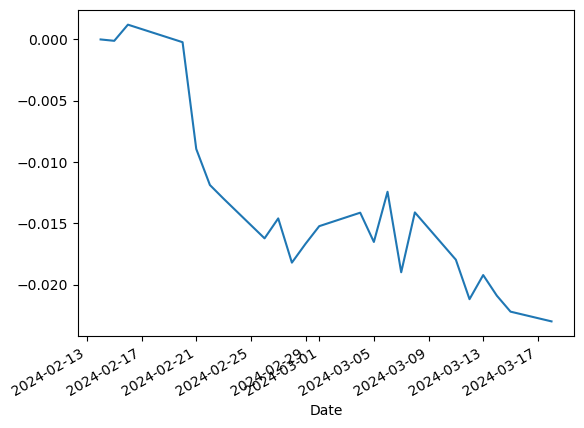

In [266]:
# use the debug levels to get more or less information
# pass your features into the list here
# be very careful when changing the above functions!
features = ['logreturns']
basic_backtest(*(load_model(hdf, features, debug=1)), fee=0.0002)

In [ ]:
# there's much more to cover in the realm of researching and testing systematic trading strategies
# importantly, we haven't covered much about risk modeling, and portfolio optimization 
# check out https://www.alacra.com/alacra/help/barra_handbook_US.pdf 
# for a good introduction to risk modeling, if you're curious!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please also check gradescope for any written assignments for this week.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)